In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [7]:
import sklearn as sk

In [8]:
df = pd.read_csv("train_lending_club.csv")

In [9]:
df['int_rate'] = np.where(np.random.rand(df['int_rate'].shape[0]) > 0.2, df['int_rate'], np.nan)
df['revol_util'] = np.where(np.random.rand(df['revol_util'].shape[0]) > 0.2, df['revol_util'], np.nan)
df['total_acc'] = np.where(np.random.rand(df['total_acc'].shape[0]) > 0.2, df['total_acc'], np.nan)

In [59]:
X = pd.DataFrame(index=df.index)

<h1>Podsumowanie zbioru, opis cech, ilości danych.</h1>

Lending Club to platforma fintech, która działa na zasadzie pożyczek społecznościowych, gdzie inwestorzy (ludzie prywatni lub instytucje finansowe) udzielają pożyczek osobom fizycznym lub firmom. Ten rodzaj platformy umożliwia inwestorom uzyskiwanie zysków z odsetek od pożyczek udzielanych innym osobom lub firmom.


Zbiór danych wybrany przez nas przedstawia problem klasyfikacji.

Posiadamy łącznie 27 cech z których wybierzemy kilka które nas interesują:

- issue_d - data, kiedy pożyczka została udzielona pożyczkobiorcy przez platformę Lending Club.
- sub_grade - kategoria oceny kredytowej
- term - określa, na ile miesięcy lub lat została udzielona pożyczka.
- home_ownership - określa, czy pożyczkobiorca jest właścicielem mieszkania/domu, wynajmuje je, czy może być wynajmującym.
- fico_range_low - skala oceny kredytowej. Ta zmienna wskazuje na dolną granicę zakresu punktacji FICO pożyczkobiorcy.
- fico_range_high - wskazuje górną granicę zakresu punktacji FICO.
- total_acc - oznacza liczbę wszystkich aktywnych i zamkniętych kont kredytowych, jakie ma pożyczkobiorca.
- pub_rec - wskazuje, ile razy pożyczkobiorca miał wpisy w rejestrze publicznym dotyczące opóźnionych płatności lub problemów kredytowych.
- revol_util - określa, ile procent dostępnego kredytu karta kredytowa lub linia kredytowa jest obecnie wykorzystywana przez pożyczkobiorcę.
- annual_inc - roczny dochód zgłoszony przez pożyczkobiorcę w swoim wniosku o pożyczkę.
- int_rate - stopa oprocentowania.
- dti - wskaźnik zadłużenia do dochodu.
- purpose - cel pożyczki.
- verification_status - określa, czy informacje podane przez pożyczkobiorcę zostały zweryfikowane w trakcie procesu aplikacji.
- loan_status - informacja, czy pożyczkobiorca dostał pożyczkę.
- loan_amnt - wielkosc pozyczki

Cały zbiór danych był bardzo duży, dlatego został on zredukowany do 236 000 rekordów.


1. Co do zmiennych numerycznych to większość z nich będzie wymagała pewnych transformacji żeby spełniały założenia modeli liniowych których planujemy użyć do bazowej predykcji. Głównie sprowadzać się to będzie do transformacji potęgowych oraz standaryzacji ale niektóre zmienne mogą potrzebować trasnformacji takich jak logarytm (zmienne exponencjalne), inwersje, exponente.
2. Zmienne kategoryczne będziemy musieli w większości zaencodować. Praktyka i testy pokażą jaki encoding najlepiej tutaj zadziała. Prawdopodobnie przetestujemy dummy/one-hot encoding, aczkolwiek być może target encoding którąś ze zmiennych zadziała dobrze jako dodatkowa zmienna (aczkolwiek to samo zadanie spełni integracja zmiennej one-hot ze zmienną targetową, więc pewnie wykorzystamy tylko jedno z tych podejść).
3. Intuicyjnie ciężko nam stwierdzić któe zmienne będzie warto ze sobą zestawiać. Wyjdzie to zresztą później na etapie modelowania gdzie będziemy mogli utworzyć dużo wariantów tych zmiennych oraz dorzućić ich integracje a następnie odseparować najlepsze z niech ze względu na poziom przydatności dla jakości predykcji.  

In [11]:
from sklearn.preprocessing import PowerTransformer

In [12]:
def power_transform(x):
    tr = PowerTransformer()
    x = tr.fit_transform(x.to_numpy().reshape(-1, 1))
    return pd.Series(x.flatten())

<AxesSubplot:>

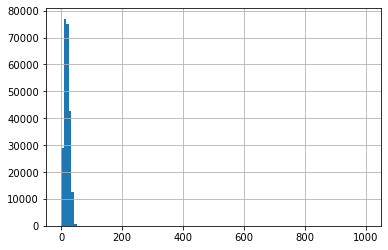

In [13]:
df['dti'].hist(bins=120)

<AxesSubplot:>

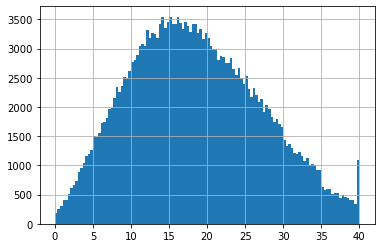

In [14]:
df['dti'].clip(0, 40).hist(bins=120)

In [15]:
# X['dti'] = power_transform(df['dti'].clip(0, 40))

Rozklad nie wymaga transformacji, ale posiada wartosci odstajace. Zmienną dodamy więc w dalszej części.

<AxesSubplot:>

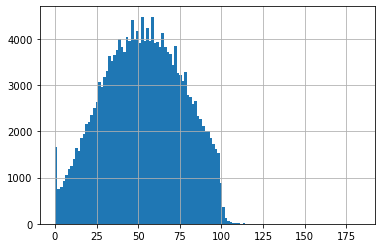

In [16]:
df['revol_util'].hist(bins=120)

In [17]:
# X['revol_util'] = power_transform(df['revol_util'].clip(0, 100))

Jak wyzej, dodatkowo na wartosc 0 warto nalozyc dodatkową flagę jako że to wartość wyróżniająca się z dystrybucji. Również zawiera wartości odstające więc dodamy ją w dalszej części projektu.

<AxesSubplot:>

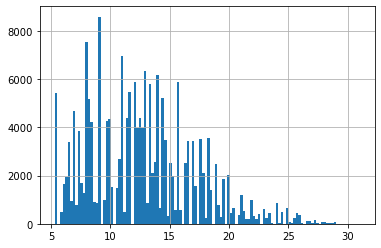

In [18]:
df['int_rate'].hist(bins=120)

<AxesSubplot:>

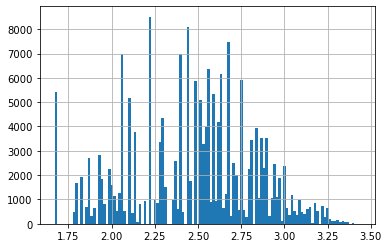

In [19]:

df['int_rate'].apply(np.log).hist(bins=120)

In [20]:
df['int_rate'].isna().value_counts()

False    189071
True      47775
Name: int_rate, dtype: int64

In [21]:
X['int_rate'] = power_transform(df['int_rate'].apply(np.log))

Zmienna przedstawia proporcje i nadaje się do transformacji logarytmicznej która poprawia rozkład zmiennej (z dystrybucji beta staje się rozkładem zbliżonym do normalnego, symetrycznym).

In [22]:
df['total_acc'].isna().value_counts()

False    189317
True      47529
Name: total_acc, dtype: int64

Nieznana wartosc srodkow na koncie jest przeslanka do wyrzucenia takiej osoby ze zbioru danych. Zmienna ta jest zbyt istotna zeby ja imputowac.

<AxesSubplot:>

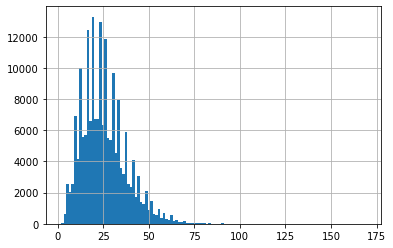

In [23]:
df['total_acc'].hist(bins=120)

<AxesSubplot:>

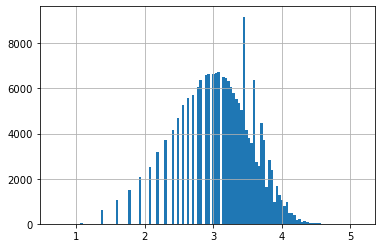

In [24]:
df['total_acc'].apply(np.log).hist(bins=120)

<AxesSubplot:>

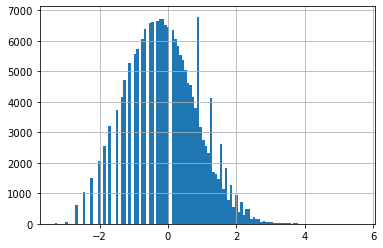

In [25]:
power_transform(df['total_acc']).hist(bins=120)

In [26]:
X['total_acc'] = power_transform(df['total_acc'])

Wielkosc sumy na koncie pozyczkobiorcy wymaga transformacji potęgowej bądź logarytmicznej. Dla prostoty zastosujemy potęgową.

<AxesSubplot:>

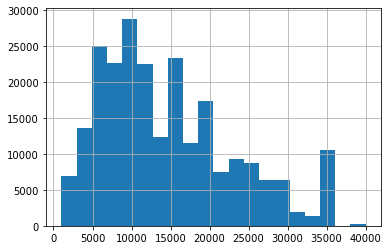

In [27]:
df['loan_amnt'].hist(bins=20)

<AxesSubplot:>

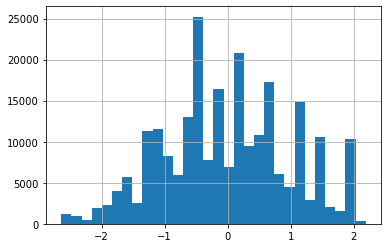

In [28]:
power_transform(df['loan_amnt']).hist(bins=30)

In [29]:
X['loan_amnt'] = power_transform(df['loan_amnt'])

Podobnie jak wyzej.

## Zmienne czasowe

1. Timestamp wskazuje na dane z ponad dwóch lat. Możliwe że żeby zrobić model, który będzie potencjalnie użyteczny trzeba będzie odłożyć końcówkę danych jako dodatkowy test set, sprawdzjący czy skuteczność modelu jest zależna od świeżości danych w stosunku do predykcji.

2. Datę możemy dodatkowo dołożyć do modelu jako ilość lat, która upłynęła od pożyczki oraz sezon (kwartal roku zgodnie z pora roku). Jeśli zmienna ta będzie miała duże znaczenie w finalnym modelu, to trzeba będzie zastosować wobec niej dodatkowe akcje.

In [30]:
df['date'] = pd.to_datetime(df['issue_d'])

In [31]:
df['date_diff_years'] = (df['date'].max() - df['date']).dt.days //365
df['season'] = (df['date'].dt.month + 2) // 3

<AxesSubplot:>

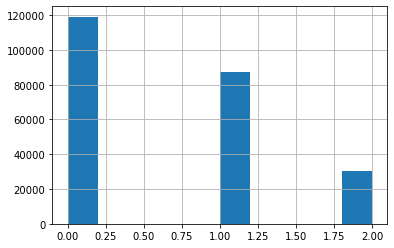

In [32]:
df['date_diff_years'].hist(bins=10)

<AxesSubplot:>

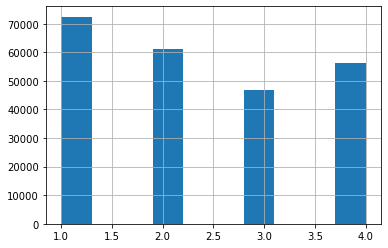

In [33]:
df['season'].hist(bins=10)

In [34]:
X = pd.concat([X, pd.get_dummies(df['season'], prefix='season')], axis=1)

In [35]:
X = pd.concat([X, pd.get_dummies(df['date_diff_years'], prefix='date_diff_years')], axis=1)

In [36]:
df.loc[:, df.dtypes[df.dtypes == np.object].index].nunique()

C:\Users\michn\AppData\Local\Temp\ipykernel_17396\2819260850.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df.loc[:, df.dtypes[df.dtypes == np.object].index].nunique()


issue_d                30
sub_grade              35
term                    2
home_ownership          3
purpose                14
application_type        2
verification_status     3
addr_state             51
initial_list_status     2
dtype: int64

In [63]:
for cat in ['verification_status', 'application_type', 'initial_list_status', 'home_ownership', 'term']:
    X = pd.concat([X, pd.get_dummies(df[cat], prefix=cat)], axis=1)

Zmienne kategoryczne, które mają więcej niż 10 wartości unikalnych:

1. add_state nie będzie brana do modelu jako zmienna geograficzna. Mogłaby być użyteczna przy odpowednim obrobieniu danych z uwzględnieniem położenia geograficznego ale wykracza to poza zakres tej analizy.

2. purpose oraz sub_grade podmienimy na target encoding za pomocą którejś znaczącej zmiennej niezależnej, bądź zmiennej zależnej.



## Wartości odstające oraz brakujące

<AxesSubplot:>

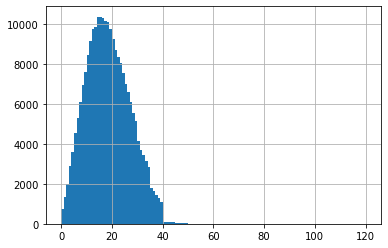

In [38]:
df['dti'].clip(0, 120).hist(bins=120)

<AxesSubplot:>

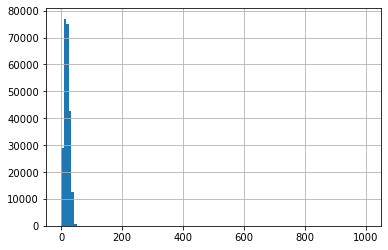

In [48]:
df['dti'].hist(bins=120)

Zmienna posiada bardzo długi ogon obserwacji powyżej 40, ze znaczącym odcięciem.

<AxesSubplot:>

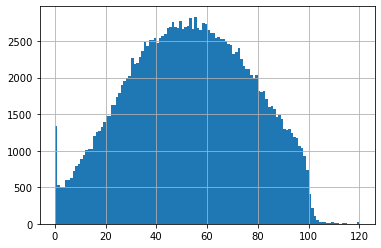

In [39]:
df['revol_util'].clip(0, 120).hist(bins=120)

<AxesSubplot:>

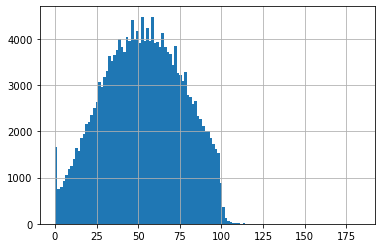

In [51]:
df['revol_util'].hist(bins=120)

<AxesSubplot:>

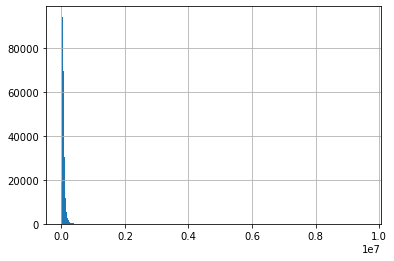

In [54]:
df['annual_inc'].hist(bins=300)

<AxesSubplot:>

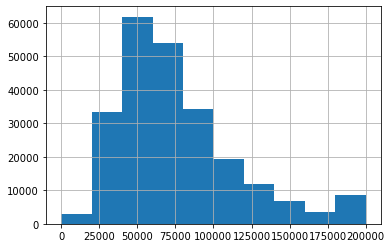

In [55]:
df['annual_inc'].clip(0, 200000).hist()

Obydwie ze zmiennych mają długie ogony z niewielką ilością wartości. Ustawienie wartości granicznej na wartości która stanowi punkt odcięcia dystrybucji wydaje się więc być dobrym wyjściem.

In [40]:
X['dti'] = power_transform(df['dti'].clip(0, 40))
X['revol_util'] = power_transform(df['revol_util'].clip(0, 100))

In [41]:
X.loc[:, ['int_rate', 'revol_util', 'total_acc']].isna().mean()

int_rate      0.201713
revol_util    0.201236
total_acc     0.200675
dtype: float64

In [42]:
X['int_rate'] = X['int_rate'].fillna(X['int_rate'].mean())

In [43]:
X['revol_util'] = X['revol_util'].fillna(X['revol_util'].median())

In [44]:
X['total_acc_target'] = df['date_diff_years'].astype(str)+df['season'].astype(str)
X['total_acc_fill'] = X.groupby('total_acc_target')['total_acc'].transform('mean')
X['total_acc'] = np.where(X['total_acc'].notna(), X['total_acc'], X['total_acc_fill'])
X = X.drop(columns=['total_acc_fill', 'total_acc_target'])


In [45]:
numerical_variables = X.columns[X.dtypes == float]

In [57]:
X

,int_rate,total_acc,loan_amnt,season_1,season_2,season_3,season_4,date_diff_years_0,date_diff_years_1,date_diff_years_2,...,application_type_Joint App,initial_list_status_f,initial_list_status_w,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,term_ 36 months,term_ 60 months,dti,revol_util
0,1.004139e+00,0.070048,0.526883,1,0,0,0,0,0,1,...,0,1,0,1,0,0,0,1,-0.318696,1.386804
1,7.548622e-01,0.070048,1.485527,1,0,0,0,0,0,1,...,0,1,0,1,0,0,0,1,-0.130247,0.033159
2,-1.109848e+00,0.070048,-1.061478,1,0,0,0,0,0,1,...,0,0,1,0,0,1,1,0,0.280588,-1.780371
3,1.004139e+00,0.070048,0.301568,1,0,0,0,0,0,1,...,0,1,0,1,0,0,0,1,0.586256,0.164393
4,6.349987e-01,-0.865114,-0.391220,1,0,0,0,0,0,1,...,0,1,0,1,0,0,1,0,0.002461,0.606052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236841,1.391489e-01,0.716896,0.830543,0,0,0,1,1,0,0,...,0,0,1,0,0,1,1,0,0.669086,1.640291
236842,-4.449030e-14,-0.865114,0.122629,0,0,1,0,1,0,0,...,0,1,0,1,0,0,1,0,0.296104,-1.481328
236843,-9.552899e-01,-0.015200,-0.391220,1,0,0,0,1,0,0,...,0,0,1,1,0,0,1,0,-0.114981,0.033159
236844,4.380335e-01,-0.044667,-0.120524,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0.465836,-0.504565


## Skalowanie zmiennych

In [46]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [47]:
#możemy wybrać metodę skalowania zmiennych numerycznych
scaler = StandardScaler()
# scaler = MinMaxScaler()

X_num_scaled = scaler.fit_transform(X[numerical_variables])
X_scaled = X.copy()
X_scaled.loc[:, numerical_variables] = X_num_scaled